## Import necessary modules

In [1]:
from nhlstats import *
from nhlstats.formatters import csv
import pandas as pd, numpy as np
from datetime import *
import ipywidgets as widgets
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import style, dates
import matplotlib.gridspec as gridspec
import datetime
from datetime import time
import time
from matplotlib.ticker import MaxNLocator
import matplotlib.collections as collections
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
%matplotlib inline 

In [2]:
today = date.today()
yesterday = today + timedelta(days=-1)

## Determine which game we want to look at


In [3]:
# Download data to pandas DF
games = pd.DataFrame(list_games(yesterday))
games = games.drop(columns=['season'])

#Create lists for all teams playing, and all game_id's
teams = []
game_ids = []
[teams.append(i) for i in games.away_team]
[teams.append(i) for i in games.home_team]
[game_ids.append(i) for i in games.game_id]

teams.sort()
def lst_unique(x):
    return list(dict.fromkeys(x))
teams = lst_unique(teams)

team_select = widgets.Dropdown(
    options=teams,
    value=teams[0],
    description='Team Name: ',
    disabled=False
)
display(games)

print("Which Team Are You Watching Today?")
display(team_select)

,away_score,away_team,date,game_id,game_state,home_score,home_team
0,2,San Jose Sharks,2020-03-12,2019021079,Final,6,Chicago Blackhawks
1,4,Winnipeg Jets,2020-03-12,2019021080,Final,2,Edmonton Oilers
2,4,St. Louis Blues,2020-03-12,2019020876,Final,2,Anaheim Ducks
3,2,New York Rangers,2020-03-12,2019021081,Final,3,Colorado Avalanche
4,2,Ottawa Senators,2020-03-12,2019021082,Final,3,Los Angeles Kings
5,0,Nashville Predators,2020-03-12,2019021083,Scheduled,0,Toronto Maple Leafs
6,0,Buffalo Sabres,2020-03-12,2019021084,Scheduled,0,Montréal Canadiens
7,0,Philadelphia Flyers,2020-03-12,2019021085,Scheduled,0,Tampa Bay Lightning
8,0,Carolina Hurricanes,2020-03-12,2019021086,Scheduled,0,New Jersey Devils
9,0,Detroit Red Wings,2020-03-12,2019021087,Scheduled,0,Washington Capitals


Which Team Are You Watching Today?


Dropdown(description='Team Name: ', options=('Anaheim Ducks', 'Arizona Coyotes', 'Buffalo Sabres', 'Calgary Fl…

## Identify `game_id` based on drop down list value. Download `plays`, `shifts`, `shots` data into DF's

In [4]:
team = team_select.value
game_id = games[(games.away_team == team) | (games.home_team == team)]['game_id'].min()

tL = pd.read_csv('teamList.csv')
Home = games[games.game_id == game_id].home_team.min()
Home = tL[tL.team_name == Home].team_abbrv.max()
Home_Color = tL[tL.team_abbrv == Home].home_c.max()

Away = games[games.game_id == game_id].away_team.min()
Away = tL[tL.team_name == Away].team_abbrv.max()
Away_Color = tL[tL.team_abbrv == Away].away_c.max()

print(f"Home: {Home} {Home_Color} \nAway: {Away} {Away_Color}")

#Columns to keep in plays and shots DF's
keys = ['datetime','event_description','event_secondary_type','event_type','period','period_time','team_for','x','y']

plays = pd.DataFrame(list_plays(game_id))
plays = plays[keys]
plays['datetime'] = pd.to_datetime(plays.datetime)

shifts = pd.DataFrame(list_shifts(game_id))   #Not sure if this DF is necessary for any part of this program

shots = pd.DataFrame(list_shots(game_id))     #`shots` is just a refined DF of `plays` and may also not be needed
shots = shots[keys]

#Identify date of game now before modifications are made to `plays`
gameday = datetime.datetime(year=plays.datetime.iloc[0].year,month=plays.datetime.iloc[0].month,day=plays.datetime.iloc[0].day)
gameday = datetime.datetime.strftime(gameday,'%d-%b-%Y')

Home: COL #6F263D 
Away: NYR #0038A8


## Seperate `shots` by team

In [5]:
x_y = shots[['event_type','team_for','x','y']]

xy_homeS = x_y[(x_y.team_for == Home) & (x_y.event_type != 'GOAL')]
xy_homeS.loc[:,'x'] = -1 * abs(xy_homeS['x'])
xy_homeG = x_y[(x_y.team_for == Home) & (x_y.event_type == 'GOAL')]
xy_homeG.loc[:,'x'] = -1 * abs(xy_homeG['x'])

xy_awayS = x_y[(x_y.team_for == Away) & (x_y.event_type != 'GOAL')]
xy_awayS.loc[:,'x'] = abs(xy_awayS['x'])
xy_awayG = x_y[(x_y.team_for == Away) & (x_y.event_type == 'GOAL')]
xy_awayG.loc[:,'x'] = abs(xy_awayG['x'])

display(xy_homeG.head())
display(xy_awayG.head())

C:\Users\grega\Python\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,event_type,team_for,x,y
21,GOAL,COL,-65.0,15.0
44,GOAL,COL,-56.0,22.0
112,GOAL,COL,-72.0,-3.0


,event_type,team_for,x,y
12,GOAL,NYR,62.0,-19.0
107,GOAL,NYR,82.0,1.0


## Seperate `hits`, `takeaways`, and `giveaways` by team

In [6]:
plays.event_type.unique()

array(['GAME_SCHEDULED', 'PERIOD_READY', 'PERIOD_START', 'FACEOFF',
       'SHOT', 'STOP', 'TAKEAWAY', 'GIVEAWAY', 'BLOCKED_SHOT', 'PENALTY',
       'HIT', 'GOAL', 'MISSED_SHOT', 'PERIOD_END', 'PERIOD_OFFICIAL',
       'GAME_END', 'GAME_OFFICIAL'], dtype=object)

In [7]:
hits = plays[plays.event_type == 'HIT'][['team_for','x','y']]
take = plays[plays.event_type == 'TAKEAWAY'][['team_for','x','y']]
give = plays[plays.event_type == 'GIVEAWAY'][['team_for','x','y']]
face = plays[plays.event_type == 'FACEOFF'][['team_for','x','y']]

xy_homeH = hits[hits.team_for == Home]           #x,y data for home team hits
xy_awayH = hits[hits.team_for == Away]           #x,y data for away team hits

xy_homeT = take[take.team_for == Home]           #x,y data for home team takeaways
xy_awayT = take[take.team_for == Away]           #x,y data for away team takeaways

xy_homeGA = give[give.team_for == Home]          #x,y data for home team giveaways
xy_awayGA = give[give.team_for == Away]          #x,y data for away team giveaways

xy_homeF = face[face.team_for == Home]           #Faceoff win xy data
xy_awayF = face[face.team_for == Away]           #Faceoff win xy data - possibly useful for looking at draws likely to win/lose

## Plot `xy shot` data for each team. Format plot to overlay ice rink

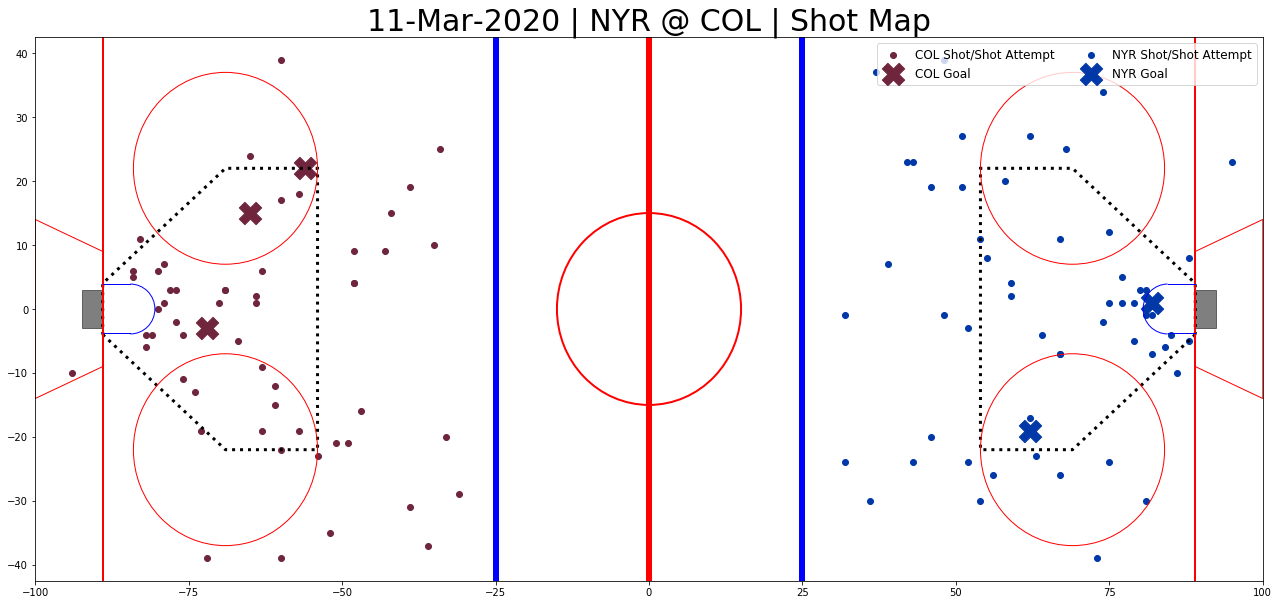

In [8]:
fig = plt.figure(figsize=(22,10))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(-42.5,42.5)
ax.set_xlim(-100,100)

########################################################################## Plot Data
a= plt.scatter(xy_homeS['x'],xy_homeS['y'],color=Home_Color)                       #Scatter plot of home team shots
b= plt.scatter(xy_homeG['x'],xy_homeG['y'],color=Home_Color,s=500, marker='X')     #Scatter plot of home team goals

c= plt.scatter(xy_awayS['x'],xy_awayS['y'],color=Away_Color)                       #Scatter plot of away team shots
d= plt.scatter(xy_awayG['x'],xy_awayG['y'],color=Away_Color,s=500, marker='X')     #Scatter plot of away team goals
##########################################################################



########################################################################## Format plot to overlay ice rink
plt.axvline(x=-89,c='r',lw=2)       #Add first goal line
plt.axvline(x=-25,c='b',lw=6)       #Add first blue line
plt.axvline(x=0,c='r',lw=6)         #Add red line
plt.axvline(x=25,c='b',lw=6)        #Add second blue line
plt.axvline(x=89,c='r', lw=2)       #Add second goal line

arc1 = patches.Arc((-84.5,0), 8,7.8,theta1=-90,theta2=90, edgecolor='b')   #Add LHS goalie crease 
rect1 = plt.Rectangle((-89-(40/12),-3), 40/12, 6, color='k', alpha = 0.5)
plt.axhline(y=3.95,xmin=(11/200),xmax=(15.5/200), c='b', lw=1)
plt.axhline(y=-3.8,xmin=(11/200),xmax=(15.5/200), c='b', lw=1)

arc2 = patches.Arc((84.5,0), 8,7.8,theta1=90,theta2=-90, edgecolor='b')   #Add RHS goalie crease 
rect2 = plt.Rectangle((89,-3), 40/12, 6, color='k', alpha = 0.5)
plt.axhline(y=3.95,xmin=(184.5/200),xmax=(189/200), c='b', lw=1)
plt.axhline(y=-3.8,xmin=(184.5/200),xmax=(189/200), c='b', lw=1)

#Add the LHS House & Trapezoid
poly1 = plt.Polygon([[-89,-4],[-69,-22],[-54,-22],[-54,22],[-69,22],[-89,4]], color='black',fill=False,lw=3,ls='dotted')
poly2 = plt.Polygon([[-100,14],[-100,-14],[-89,-9],[-89,9]], color='r',fill=False, lw = 1)

#Add the RHS House & Trapezoid
poly3 = plt.Polygon([[89,-4],[69,-22],[54,-22],[54,22],[69,22],[89,4]], color='black',fill=False, lw=3,ls='dotted')
poly4 = plt.Polygon([[100,14],[100,-14],[89,-9],[89,9]], color='r',fill=False, lw = 1)

circ1 = plt.Circle((-69,22), 15, ec='r',fill=False, lw=1)                 #LHS top faceoff circle
circ2 = plt.Circle((-69,-22), 15, ec='r',fill=False, lw=1)                #LHS bottom faceoff circle
circ3 = plt.Circle((0,0), 15, ec='r', fill=False, lw=2)                   #Center Ice Circle
circ4 = plt.Circle((69,22), 15, ec='r',fill=False, lw=1)                  #RHS top faceoff circle
circ5 = plt.Circle((69,-22), 15, ec='r',fill=False, lw=1)                 #RHS bottom faceoff circle

ax.add_patch(poly1)       #Add LHS House
ax.add_patch(poly2)       #Add LHS trapezoid
ax.add_patch(poly3)       #Add RHS House
ax.add_patch(poly4)       #Add RHS trapezoid

ax.add_patch(rect1)       #Add LHS goal net
ax.add_patch(rect2)       #Add RHS goal net

ax.add_patch(arc1)        #Add LHS arc of goal crease
ax.add_patch(arc2)        #Add RHS arc of goal crease

ax.add_patch(circ1)       #Add LHS top faceoff circle
ax.add_patch(circ2)       #Add LHS bottom faceoff circle
ax.add_patch(circ3)       #Add center ice circle
ax.add_patch(circ4)       #Add RHS top faceoff circle
ax.add_patch(circ5)       #Add RHS bottom faceoff circle

#plt.axhline(y=0)
mpl.rc('axes', titlesize=30)                           #fontsize of the axes title
plt.title(f"{gameday} | {Away} @ {Home} | Shot Map")

plt.legend((a,b,c,d), (Home + ' Shot/Shot Attempt',\
                       Home + ' Goal',\
                       Away + ' Shot/Shot Attempt',\
                       Away + ' Goal'),\
                       scatterpoints=1,loc=0,ncol=2,fontsize=12)
#ax.set_xticks([])
#ax.set_yticks([])
plt.savefig(f"{gameday} {Away} @ {Home} - Shot Map.png")
plt.show()

## Plot `xy hits, takeaway, giveaway` data for each team. Format plot to overlay ice rink

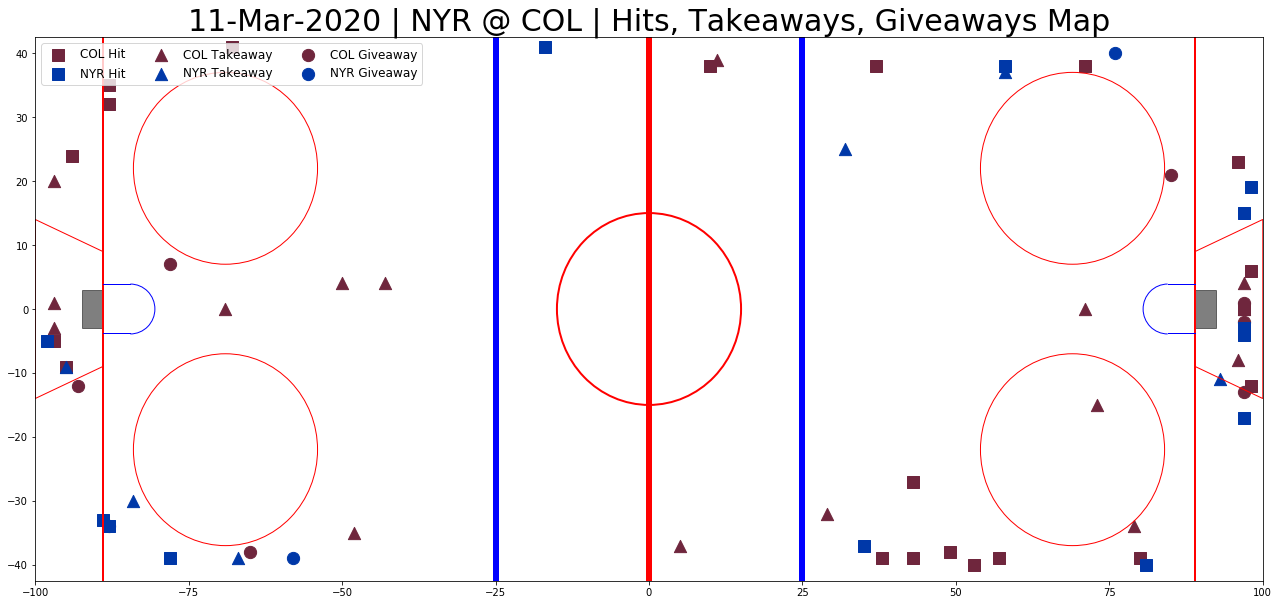

In [9]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(1,1,1)
ax1.set_ylim(-42.5,42.5)
ax1.set_xlim(-100,100)

########################################################################## Plot Data
a= plt.scatter(xy_homeH['x'],xy_homeH['y'],color=Home_Color, s=150, marker='s')    #Scatter plot of home team hits
b= plt.scatter(xy_homeT['x'],xy_homeT['y'],color=Home_Color,s=150, marker='^')     #Scatter plot of home team takeaways
c= plt.scatter(xy_homeGA['x'],xy_homeGA['y'],color=Home_Color,s=150, marker='o')   #Scatter plot of home team giveaways

d= plt.scatter(xy_awayH['x'],xy_awayH['y'],color=Away_Color, s=150, marker='s')    #Scatter plot of away team hits
e= plt.scatter(xy_awayT['x'],xy_awayT['y'],color=Away_Color,s=150, marker='^')     #Scatter plot of away team takeaways
f= plt.scatter(xy_awayGA['x'],xy_awayGA['y'],color=Away_Color,s=150, marker='o')   #Scatter plot of away team giveaways
##########################################################################


########################################################################## Format plot to overlay ice rink
plt.axvline(x=-89,c='r',lw=2)       #Add first goal line
plt.axvline(x=-25,c='b',lw=6)       #Add first blue line
plt.axvline(x=0,c='r',lw=6)         #Add red line
plt.axvline(x=25,c='b',lw=6)        #Add second blue line
plt.axvline(x=89,c='r', lw=2)       #Add second goal line

arc1 = patches.Arc((-84.5,0), 8,7.8,theta1=-90,theta2=90, edgecolor='b')   #Add LHS goalie crease 
rect1 = plt.Rectangle((-89-(40/12),-3), 40/12, 6, color='k', alpha = 0.5)
plt.axhline(y=3.95,xmin=(11/200),xmax=(15.5/200), c='b', lw=1)
plt.axhline(y=-3.8,xmin=(11/200),xmax=(15.5/200), c='b', lw=1)

arc2 = patches.Arc((84.5,0), 8,7.8,theta1=90,theta2=-90, edgecolor='b')   #Add RHS goalie crease 
rect2 = plt.Rectangle((89,-3), 40/12, 6, color='k', alpha = 0.5)
plt.axhline(y=3.95,xmin=(184.5/200),xmax=(189/200), c='b', lw=1)
plt.axhline(y=-3.8,xmin=(184.5/200),xmax=(189/200), c='b', lw=1)

#Add the LHS House & Trapezoid
#poly1 = plt.Polygon([[-89,-4],[-69,-22],[-54,-22],[-54,22],[-69,22],[-89,4]], color='black',fill=False, lw=3)
poly2 = plt.Polygon([[-100,14],[-100,-14],[-89,-9],[-89,9]], color='r',fill=False, lw = 1)

#Add the RHS House & Trapezoid
#poly3 = plt.Polygon([[89,-4],[69,-22],[54,-22],[54,22],[69,22],[89,4]], color='black',fill=False, lw=3)
poly4 = plt.Polygon([[100,14],[100,-14],[89,-9],[89,9]], color='r',fill=False, lw = 1)

circ1 = plt.Circle((-69,22), 15, ec='r',fill=False, lw=1)                 #LHS top faceoff circle
circ2 = plt.Circle((-69,-22), 15, ec='r',fill=False, lw=1)                #LHS bottom faceoff circle
circ3 = plt.Circle((0,0), 15, ec='r', fill=False, lw=2)                   #Center Ice Circle
circ4 = plt.Circle((69,22), 15, ec='r',fill=False, lw=1)                  #RHS top faceoff circle
circ5 = plt.Circle((69,-22), 15, ec='r',fill=False, lw=1)                 #RHS bottom faceoff circle

#ax1.add_patch(poly1)       #Add LHS House
ax1.add_patch(poly2)       #Add LHS trapezoid
#ax1.add_patch(poly3)       #Add RHS House
ax1.add_patch(poly4)       #Add RHS trapezoid

ax1.add_patch(rect1)       #Add LHS goal net
ax1.add_patch(rect2)       #Add RHS goal net

ax1.add_patch(arc1)        #Add LHS arc of goal crease
ax1.add_patch(arc2)        #Add RHS arc of goal crease

ax1.add_patch(circ1)       #Add LHS top faceoff circle
ax1.add_patch(circ2)       #Add LHS bottom faceoff circle
ax1.add_patch(circ3)       #Add center ice circle
ax1.add_patch(circ4)       #Add RHS top faceoff circle
ax1.add_patch(circ5)       #Add RHS bottom faceoff circle

#plt.axhline(y=0)
mpl.rc('axes', titlesize=30)  #fontsize of the axes title
plt.title(f"{gameday} | {Away} @ {Home} | Hits, Takeaways, Giveaways Map")

plt.legend((a,d,b,e,c,f),\
           (Home + ' Hit', Away + ' Hit', Home + ' Takeaway',\
            Away + ' Takeaway', Home + ' Giveaway', Away + ' Giveaway'),\
            scatterpoints=1, loc=0, ncol=3, fontsize=12)

#ax1.set_xticks([])
#ax1.set_yticks([])
plt.savefig(f"{gameday} {Away} @ {Home} - Hits, Takeaways, Giveaways Map.png")
plt.show()